In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

## Считаем данные и проверим на пропуски

In [2]:
raw_data = pd.read_csv('behavior.csv')
raw_data.head()

,Unnamed: 0,hkey_local_machine\\software\microsoft\windows\currentversion\uninstall\mobileoptionpack,hkey_classes_root\\clsid\{148bd52a-a2ab-11ce-b11f-00aa00530503},hkey_current_user\\software\microsoft\windows\currentversion\urlmon settings,hkey_local_machine\\system\currentcontrolset\services\tcpip\parameters\interfaces\ms tcp loopback interface,hkey_local_machine\\software\microsoft\net framework setup\ndp\v3.5,hkey_local_machine\\software\microsoft\windows nt\currentversion\winlogon,hkey_local_machine\\software\microsoft\windows\currentversion\internet settings\user agent,hkey_local_machine\\system\currentcontrolset\services\dnscache\parameters,hkey_current_user\\software\microsoft\windows\currentversion\explorer\mountpoints2\cpc\volume,...,c:\windows\system32\kernel32.dll,c:\documents and settings\username\application data\microsoft\cryptneturlcache\metadata\2bf68f4714092295550497dd56f57004,c:\windows\system32\shdocvw.dll,c:\windows\system32\psapi.dll,c:\windows\system32\cmd.exe,c:\windows\dll\mscorlib.pdb,\\.\vboxguest,unnamedfile,wdmaud.drv_file,tag
0,00005122106941E2A0B5A651249D71ADD11C561167F3F9...,0,0,0,0,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0000CF95A98B33F00F4CDCBD13017EAB7B9589BE79617D...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00015A2AEE06230C7E12B8D1E79F345F90008F0DD3175B...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0001D0A0243A15D78F10DB87FD721E4F06F3B9892257FC...,0,0,0,0,0,4,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0001D6A56EBCF3C0DEF053DA01454BF23021DE7DF1FC48...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
raw_data.isna().sum().unique()

array([0], dtype=int64)

## Пропусков нет, работаем с данными. Для оценки важности признаков посчитаем корреляцию каждого с ответом и начертим гистограмму распределения корреляций

In [4]:
data = raw_data

In [5]:
correlations = []
for i in range(data.columns.shape[0] - 2):
    correlations.append(np.corrcoef(raw_data['tag'], raw_data.iloc[:, i + 1])[0][1])

D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


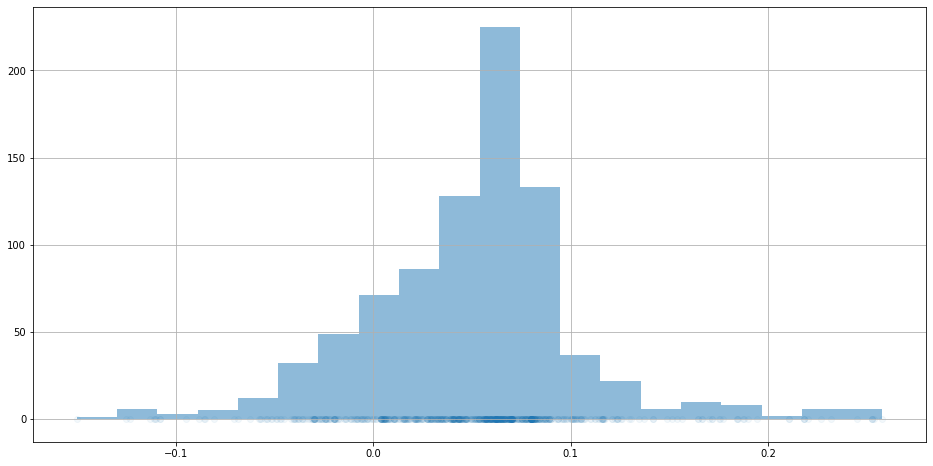

In [6]:
plt.figure(figsize=(16, 8))

plt.hist(correlations, bins=20, alpha=0.5, label='Correlation')
plt.scatter(correlations, np.zeros(len(correlations)), alpha=0.05)

plt.grid(':')
plt.show()

## Попробуем посмотреть на имена файлов, у которых корелляция > 0.1

In [7]:
feature_index = []
for i in range(data.columns.shape[0] - 2):
    if np.abs(correlations[i]) > 0.1:
        feature_index.append(i + 1)
len(feature_index), data.columns[feature_index]

(97,
 Index(['hkey_classes_root\\clsid\{148bd52a-a2ab-11ce-b11f-00aa00530503}',
        'hkey_local_machine\\software\microsoft\windows\currentversion\internet settings\user agent',
        'hkey_local_machine\\software\microsoft\internet explorer',
        'hkey_current_user\\software\microsoft\windows\currentversion\internet settings\5.0\user agent',
        'hkey_local_machine\\software\policies\microsoft\windows nt\rpc',
        'hkey_local_machine\\software\microsoft\internet explorer\main\featurecontrol',
        'hkey_local_machine\\system\currentcontrolset\services\netbt\parameters',
        'hkey_local_machine\\software\microsoft\command processor',
        'hkey_local_machine\\system\setup',
        'hkey_classes_root\\http\shell\open\command',
        'hkey_current_user\\software\microsoft\windows\shell\associations\urlassociations\http\userchoice',
        'hkey_local_machine\\software\microsoft\windows\currentversion\explorer',
        'hkey_local_machine\\software\microso

## Большинство файлов - файлы реестра. Сделаем 6 выборок - полную, выборку с файлами реестра, выборку с файлами, чья корреляция > 0.01, > 0.05 и > 0.1

In [8]:
FEATURE_SAMPLE_NUMBER = 6
X = [0 for i in range(FEATURE_SAMPLE_NUMBER)]
y = [0 for i in range(FEATURE_SAMPLE_NUMBER)]

selection_function = [lambda i: True,
           lambda i: data.columns[i].find('hkey') != -1,
           lambda i: (data.columns[i].find('hkey') != -1) or (data.columns[i].find('c:') != -1),
           lambda i: np.abs(correlations[i - 1]) > 0.01,
           lambda i: np.abs(correlations[i - 1]) > 0.05,
           lambda i: np.abs(correlations[i - 1]) > 0.1]

for sample_number in range(FEATURE_SAMPLE_NUMBER):
    feature_index = []
    for i in range(data.columns.shape[0] - 2):
        if selection_function[sample_number](i + 1):
            feature_index.append(i + 1)
    
    X[sample_number] = data.iloc[:, feature_index].to_numpy()
    y[sample_number] = data.iloc[:, data.columns.shape[0] - 1].to_numpy()

In [9]:
X_train = [0 for i in range(FEATURE_SAMPLE_NUMBER)]
X_test = [0 for i in range(FEATURE_SAMPLE_NUMBER)]
y_train = [0 for i in range(FEATURE_SAMPLE_NUMBER)]
y_test = [0 for i in range(FEATURE_SAMPLE_NUMBER)]

for i in range(FEATURE_SAMPLE_NUMBER):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], random_state=42)
    print(i, X_train[i].shape)

0 (37500, 853)
1 (37500, 403)
2 (37500, 559)
3 (37500, 780)
4 (37500, 502)
5 (37500, 97)


## Пришло время моделей!!! Для начала - каждую обучим на каждой из выборок. Для каждой посчитаем accuracy и recall. Первую метрику возьмём просто для общего понимания. Почему же нам нужна вторая, recall? Так как мы классифицируем программу как "вредоносную" и "не вредоносную", то хотим уменьшить False Positive (не страшно, если некоторые не вредоносные программы будут определяться, как вредоносные, главное - определить большее кол-во вредоносных правильно), а за это как раз отвечает recall-функция.

## Теперь поговорим об используемых моделях. Для начала я решил попробовать стандартные реализованные модели из sklearn.
### 1) K Nearest Neighbours
### 2) Decision Tree
### 3) Random Forest
### 4) Extra Trees
### 5) AdaBoost
### Методом проб и ошибок и подобрав параметры, показывающие лучший recall на тестовой выборке, пришёл к данным параметрам (см следующую клетку c кодом)
### Также я решил попробовать Voting classifier на KNN, ExtraTrees и RandomForest с коэффициентом 1:1:1

In [10]:
CLASSIFIERS_NUM = 6
classifiers = []
for i in range(FEATURE_SAMPLE_NUMBER):
    extra = ExtraTreesClassifier(n_jobs=-1)
    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    forest = RandomForestClassifier(max_depth=80, n_estimators=40, max_features='auto', n_jobs=-1)
    classifiers.append([
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        DecisionTreeClassifier(max_depth=70, max_features='auto'),
        RandomForestClassifier(max_depth=80, n_estimators=40, max_features='auto', n_jobs=-1),
        ExtraTreesClassifier(n_jobs=-1),
        AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, max_features='auto')),
        VotingClassifier(estimators=[('extra', extra), ('knn', knn), ('forest', forest)], 
                         voting='soft', weights=[1, 1, 1])
    ])

### Обучим модели и посчитаем время обучения и предсказания тестовой выборки

In [11]:
names = ['KNN-5', 'Decision Tree', 'Random Forest', 'Extra Trees', 'Ada Boost', 'Voting (KNN:ExtraTrees:RandomForest=1:1:1)']
sets = ['Whole set', 'Only register', 'Register + files with full path', 'Correlation > 0.01', 'Correlation > 0.05', 'Correlation > 0.1']

times = pd.DataFrame(columns=['Algorithm', 'Sample set', 'Fitting time', 'Prediction time'],
                    index=[x for x in range(CLASSIFIERS_NUM * FEATURE_SAMPLE_NUMBER)])
acc = []
recall = []
for i in range(CLASSIFIERS_NUM):
    tmp_acc = []
    tmp_recall = []
    for j in range(FEATURE_SAMPLE_NUMBER):
        
        fit_time = time.time()
        classifiers[j][i].fit(X_train[j], y_train[j])
        fit_time = round(time.time() - fit_time, 2)
        
        predict_time = time.time()
        prediction = classifiers[j][i].predict(X_test[j])
        predict_time = round(time.time() - predict_time, 2)
        
        times.iloc[i * 6 + j, :] = [names[i], sets[j], fit_time, predict_time]
        # print(names[i], ',', sets[j], ',', fit_time, ',', predict_time)
        
        report = classification_report(y_test[j], prediction, output_dict=True)
        tmp_acc.append(report['accuracy'])
        tmp_recall.append(report['1']['recall'])
    acc.append(tmp_acc)
    recall.append(tmp_recall)

### Посмотрим все accuracy и recall

In [12]:
pd_acc = pd.DataFrame(acc, index=names)
pd_acc.columns = sets

pd_acc

,Whole set,Only register,Register + files with full path,Correlation > 0.01,Correlation > 0.05,Correlation > 0.1
KNN-5,0.86376,0.79736,0.76664,0.86240,0.85264,0.83736
Decision Tree,0.87080,0.80656,0.81448,0.86368,0.86760,0.84808
Random Forest,0.90072,0.81640,0.82616,0.90072,0.88440,0.86672
Extra Trees,0.90144,0.81592,0.82656,0.89520,0.88584,0.86720
Ada Boost,0.87792,0.81184,0.81600,0.87648,0.86768,0.85024
Voting (KNN:ExtraTrees:RandomForest=1:1:1),0.89888,0.81520,0.82560,0.89840,0.88368,0.86760


In [13]:
pd_recall = pd.DataFrame(recall, index=names)
pd_recall.columns = sets

pd_recall

,Whole set,Only register,Register + files with full path,Correlation > 0.01,Correlation > 0.05,Correlation > 0.1
KNN-5,0.902089,0.727152,0.900311,0.900311,0.829359,0.808769
Decision Tree,0.896164,0.740483,0.741520,0.839431,0.834247,0.808621
Random Forest,0.923123,0.752481,0.763294,0.923715,0.851874,0.828322
Extra Trees,0.923123,0.750259,0.760184,0.866686,0.849948,0.826692
Ada Boost,0.850689,0.751444,0.753222,0.842097,0.840024,0.814842
Voting (KNN:ExtraTrees:RandomForest=1:1:1),0.924456,0.750852,0.766701,0.924159,0.854392,0.831581


In [14]:
times

,Algorithm,Sample set,Fitting time,Prediction time
0,KNN-5,Whole set,9.11,7.47
1,KNN-5,Only register,5.53,14.1
2,KNN-5,Register + files with full path,7.18,13.83
3,KNN-5,Correlation > 0.01,8.43,6.78
4,KNN-5,Correlation > 0.05,5.28,2.26
5,KNN-5,Correlation > 0.1,1.02,0.67
6,Decision Tree,Whole set,0.33,0.03
7,Decision Tree,Only register,0.21,0.01
8,Decision Tree,Register + files with full path,0.28,0.02
9,Decision Tree,Correlation > 0.01,0.3,0.03


### Итак, лучше всего себя показала модель голосования. Разумеется, следует учитывать, что её время обучения и предсказания сильно больше, чем у её подмоделей.

### Также видно, что все отборы признаков показали себя хуже, чем обучения на полном множестве признаков. В будущем следует изучить тему отбора фич более глубоко и применить знания.

### Лучшая обученная модель - VotingClassifier c подмоделями 

#### ExtraTreesClassifier(n_jobs=-1)
#### KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
#### RandomForestClassifier(max_depth=80, n_estimators=40, max_features='auto', n_jobs=-1)

### и отношением 1:1:1 на полной выборке и выборке с $corrcoef>0.01$
### $recall_{Whole set}=92.4\%, recall_{corrcoef>0.01}=92.4\%$